# Question 1

The D-dimensional Schwefel function:

$$f(x_1, x_2, \cdots,x_D) = 418.9829D - \sum_i^D x_i\sin(\sqrt{|x_i|})$$

where $x_i\in[-500, 500]$ for $i=1,2,\cdots,D$.

*For debugging*: The global minimum is 0, which is reached at $x_i=420.9687$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# CG optimization with scipy
from scipy.optimize import minimize

In [2]:
def Schwefel(X):
    res = 0
    D = len(X)
    for i in range(D):
        res += X[i] * np.sin(np.sqrt(np.abs(X[i])))
    return 418.9829 * D - res

# for visualization if you want
def plot_surface(func, x_min=-2, x_max=2, y_min=-2, y_max=2):
    a = np.linspace(x_min, x_max, 100)
    b = np.linspace(y_min, y_max, 100)
    x,y = np.meshgrid(a, b)
    z = func((x, y))
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(x, y, z)

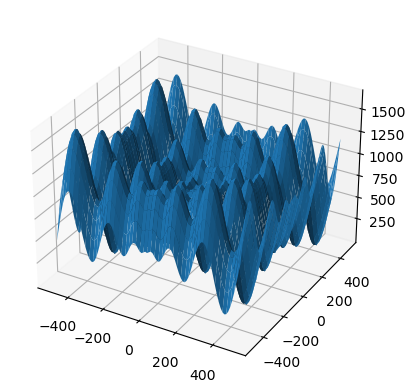

In [3]:
plot_surface(Schwefel, -500, 500, -500, 500)

In [4]:
def SA(solution, func, schedule, delta, boundary, n_iter=10, report_interval=None):
    """ 
    Simulated Annealing for minimization
    
    Parameters
    ----------
    solution: np.ndarray
        Initial guess
    func: Callable
        Function to minimize
    schedule: np.ndarray
        An array of temperatures for simulated annealing
    delta: float
        Magnitude of random displacement
    boundary: tuple
        Boundary of the variables to minimize. (lowerbound,upperbound)
    n_iter: int
        Number of random displacement move in each temperature
    report_interavl: int
        Number of temperature steps to report result
    
    Returns
    -------
    res: dict
        Minimized point and its evaulation value
    """
    
    best_solution = solution.copy()
    lowest_eval = func(best_solution)
    
    for idx, temp in enumerate(schedule):
        if report_interval is not None and ((idx + 1) % report_interval == 0 or idx == 0):
            msg = (
                f"{idx + 1}/{len(schedule)}, Temp: {temp:.2f}, "
                f"Best solution: {best_solution}, Value: {lowest_eval:.7f}"
            )
            print(msg)
        
        for n in range(n_iter):
            trial = solution.copy()
            # do a random displacement
            trial += delta * (2 * np.random.random(trial.shape) - 1)
            if np.all(trial >= boundary[0]) and np.all(trial <= boundary[1]):
                # fill in acceptance criterion
                if np.exp(-(func(trial) - func(solution)) / temp) > np.random.random():
                    solution = trial
                    if func(solution) < lowest_eval:
                        # update solution here
                        best_solution = solution.copy()
                        lowest_eval = func(best_solution)
                        
    return {"solution":best_solution, "evaluation":lowest_eval}

In [5]:
starting = 500 * (np.random.random(10) * 2 - 1)
starting

array([-442.28207177, -313.36651559, -147.59027119, -389.44779179,
        354.65421   ,  364.07885368,   54.49094331,  -74.11547349,
        317.84105368, -226.47606894])

## (a)

*For debugging*: 

Length of schedule 5941 for 30K, 5981 for 10K (both initial temperature and final temperature are included in the schedule). The function evaluation of your solution usually falls in the range of 2000~4000 with `delta=0.5` and `n_iter=10`. 

In [6]:
def linear_cooling(init_temp, final_temp, alpha):
    temp = init_temp
    temperatures = [temp]
    
    while temp > final_temp:
        temp -= alpha
        temperatures.append(temp)
    
    return np.array(temperatures)

In [7]:
schedule_30k = linear_cooling(3000, 30, alpha=0.5)
print(f"len(schedule_30k): {len(schedule_30k)}")
schedule_10k = linear_cooling(3000, 10, alpha=0.5)
print(f"len(schedule_10k): {len(schedule_10k)}")

len(schedule_30k): 5941
len(schedule_10k): 5981


**ANSWER:** The cooling schedules have the good length.

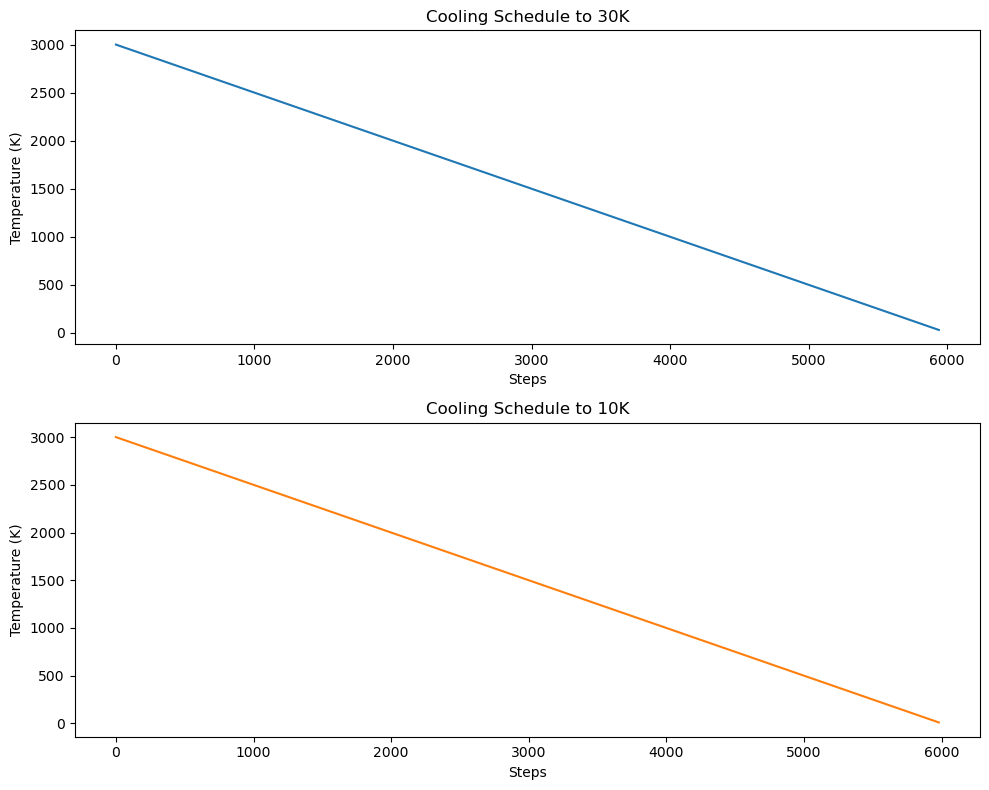

In [8]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# First subplot for cooling to 30K
axs[0].plot(schedule_30k)
axs[0].set_title('Cooling Schedule to 30K')
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Temperature (K)')

# Second subplot for cooling to 10K
axs[1].plot(schedule_10k, 'tab:orange')
axs[1].set_title('Cooling Schedule to 10K')
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('Temperature (K)')

# Adjust layout to not overlap
plt.tight_layout()

# Show plot
plt.show()

In [9]:
def statistics_test(method, args, times, global_minimum=None, verbose=False):
    result = []
    for n in range(times):
        res = method(**args)
        
        # If the norm of the difference vector between the global minimum
        # and the resulting point is larger than 1e-3, the point will not
        # be considered as a global minimum
        if (global_minimum is not None) and (np.linalg.norm(res["x"] - global_minimum) > 1e-3):
            continue
        if method == minimize:
            result.append(res.fun)
        else:
            result.append(res["evaluation"])

    if (global_minimum is not None):
        msg = f"Running {times} times: reach global minimum {len(result)} times"
    else:
        msg = f"Running {times} times"
    if len(result) > 0:
        avg = np.mean(result) # calculate the average
        std = np.std(result) # calculate the standard deviation
        msg += f", average {int(avg)} steps with variance {std:.2f}"
    if verbose: 
        print(msg)
    return avg, std

In [10]:
avg_30k, std_30k = statistics_test(SA, args=({"solution": starting, "func": Schwefel, "schedule": schedule_30k, "delta": 0.5, "boundary": (-500, 500), "n_iter": 10, "report_interval":None}), times=3)
avg_10k, std_10k = statistics_test(SA, args=({"solution": starting, "func": Schwefel, "schedule": schedule_10k, "delta": 0.5, "boundary": (-500, 500), "n_iter": 10, "report_interval":None}), times=3)


In [11]:
# Print average & standard deviation of minimized values of 3 runs
print(f"Minimized values at 30K: {avg_30k} +/- {std_30k}")
print(f"Minimized values at 10K: {avg_10k} +/- {std_10k}")

Minimized values at 30K: 3371.8646935722177 +/- 103.49620247304179
Minimized values at 10K: 3028.4374554790643 +/- 761.4410296329548


**ANSWER:** On average, cooling to the lower temperature gives the best result.

## (b)

*For debugging*:

The final temperature should be 326.10415680714726 (starting from 6000K) or 309.29382323518576 (starting from 3000K).

In [12]:
def log_cooling(init_temp, sigma, k):
    temperatures = []
    
    for i in range(k):
        temp = init_temp / (1 + (init_temp * np.log(1 + i))/(3 * sigma))
        temperatures.append(temp)
    
    return np.array(temperatures)

In [13]:
schedule_6000k = log_cooling(6000, sigma=1000, k=6000)
assert schedule_6000k[-1] == 326.10415680714726
print(f"schedule_6000k[-1]: {schedule_6000k[-1]}")
schedule_3000k = log_cooling(3000, sigma=1000, k=6000)
assert schedule_3000k[-1] == 309.29382323518576
print(f"schedule_3000k[-1]: {schedule_3000k[-1]}")

schedule_6000k[-1]: 326.10415680714726
schedule_3000k[-1]: 309.29382323518576


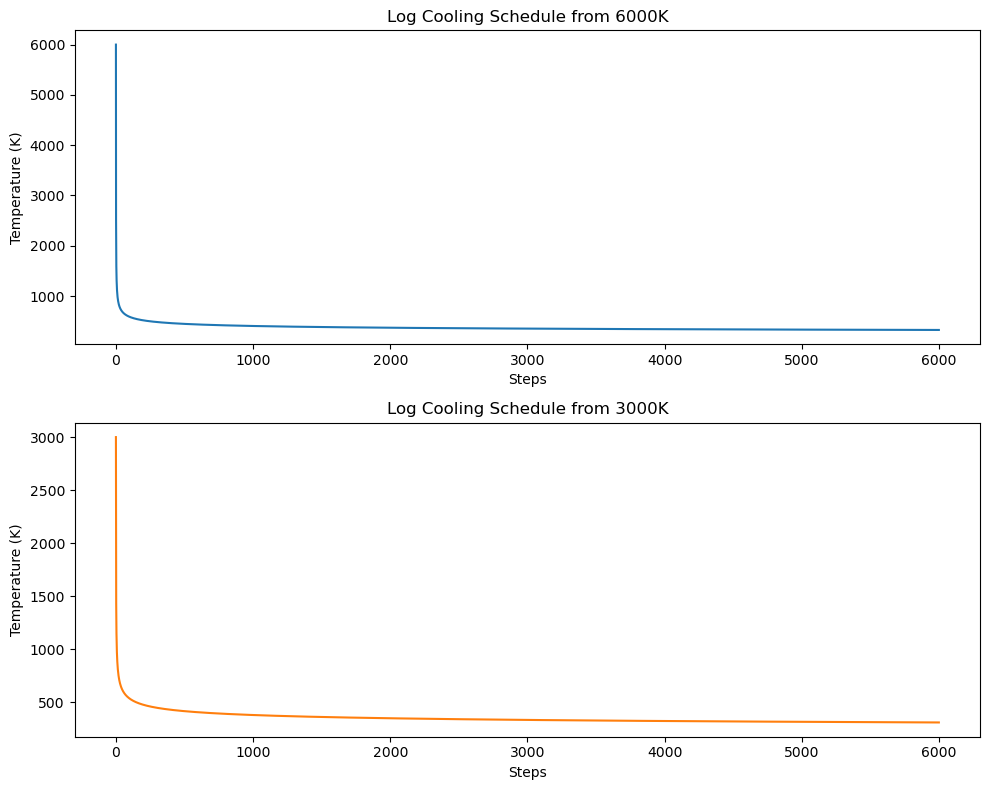

In [14]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# First subplot for cooling from 6000K
axs[0].plot(schedule_6000k)
axs[0].set_title('Log Cooling Schedule from 6000K')
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Temperature (K)')

# Second subplot for cooling from 3000K
axs[1].plot(schedule_3000k, 'tab:orange')
axs[1].set_title('Log Cooling Schedule from 3000K')
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('Temperature (K)')

# Adjust layout to not overlap
plt.tight_layout()

# Show plot
plt.show()

In [75]:
avg_6000k, std_6000k = statistics_test(SA, args=({"solution": starting, "func": Schwefel, "schedule": schedule_6000k, "delta": 0.5, "boundary": (-500, 500), "n_iter": 10, "report_interval":None}), times=3)
avg_3000k, std_3000k = statistics_test(SA, args=({"solution": starting, "func": Schwefel, "schedule": schedule_3000k, "delta": 0.5, "boundary": (-500, 500), "n_iter": 10, "report_interval":None}), times=3)

In [76]:
# Print average & standard deviation of minimized values of 3 runs
print(f"Minimized values starting from 6000K: {avg_6000k} +/- {std_6000k}")
print(f"Minimized values starting from 3000K: {avg_3000k} +/- {std_3000k}")

Minimized values starting from 6000K: 2946.163771061159 +/- 418.3407880870615
Minimized values starting from 3000K: 2673.583032251619 +/- 198.16871893458904


**ANSWER:** Starting at a lower temperature (3000K) seems to give better results. The results are better than linear cooling, the minimized values are lower on average than with linear cooling.

## (c) 

For this question, we can try the geometric cooling schedule as we saw in class.

In [17]:
import warnings

# Ignore specific runtime warnings
warnings.filterwarnings('ignore', 'overflow encountered in exp')

In [18]:
def geometric_cooling(init_temp, alpha, k): # the number of steps in the schedule
    if alpha == 1:
        print("Warning: infinite loop predicted!")
        return
    return init_temp*np.geomspace(1, alpha**(k-1),k) # we use the np.geomspace library

In [19]:
# construct your cooling schedule
schedule = geometric_cooling(6000, alpha=0.9, k=6000)

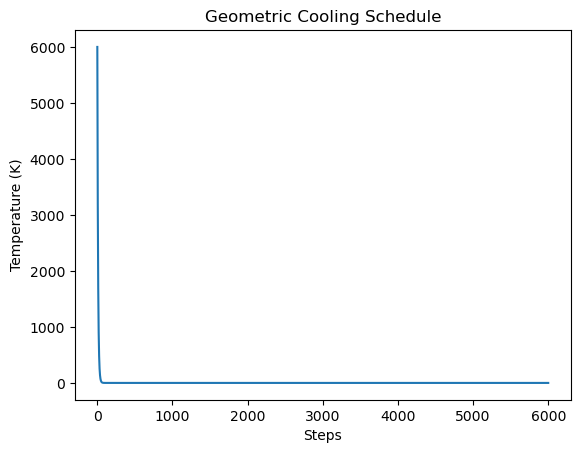

In [20]:
# Create a figure and a set of subplots
plt.plot(schedule)
plt.title('Geometric Cooling Schedule')
plt.xlabel('Steps')
plt.ylabel('Temperature (K)')

# Show plot
plt.show()

**ANSWER:** According to the plot, the time spent are small temperatures is longer than with the log cooling or the linear cooling.

In [21]:
def SA_CG(solution, func, schedule, delta, boundary, n_iter=10, report_interval=None, tol=1e-5, verbose=False):
    result = SA(solution=solution, func=func, schedule=schedule, delta=delta, boundary=boundary, n_iter=n_iter, report_interval=report_interval)
    CSA_solution, CSA_evaluation = result["solution"], result["evaluation"]

    if verbose: 
        print(f"Function minimum with SA only: {CSA_evaluation}")

    res_cg = minimize(Schwefel, CSA_solution, method='CG', tol=tol)
    
    if verbose: 
        print("\nSA+CG optimization:")
        print("Function minimum:", res_cg.fun)
        print("Found at:", res_cg.x)
        print("Number of iterations:", res_cg.nit)

    return {"solution":res_cg.x, "evaluation":res_cg.fun, "nit": res_cg.nit}

The first test of this type of schedule:

In [22]:
SA_CG(solution=starting, func=Schwefel, schedule=schedule, delta=0.5, boundary=(-500, 500), n_iter=10, report_interval=None, tol=1e-5, verbose=True)

Function minimum with SA only: 1541.3005420226214

SA+CG optimization:
Function minimum: 1164.7000540258314
Found at: [-559.14872909 -302.52497296 -124.82928438 -302.52486954  420.9687372
  420.96876632   65.54776249 -124.82936972  420.9687459  -302.52482968]
Number of iterations: 8


{'solution': array([-559.14872909, -302.52497296, -124.82928438, -302.52486954,
         420.9687372 ,  420.96876632,   65.54776249, -124.82936972,
         420.9687459 , -302.52482968]),
 'evaluation': 1164.7000540258314,
 'nit': 8}

**ANSWER:** It seems that it can give better results than with the two other schedule methods.

Now test on several runs:

In [23]:
schedule = geometric_cooling(6000, alpha=0.9, k=6000)

In [24]:
avg_SA_geo, std_SA_geo = statistics_test(SA, args=({"solution": starting, "func": Schwefel, "schedule": schedule, "delta": 0.5, "boundary": (-500, 500), "n_iter": 10, "report_interval":None}), times=3)
avg_SA_CG_geo, std_SA_CG_geo = statistics_test(SA_CG, args=({"solution": starting, "func": Schwefel, "schedule": schedule, "delta": 0.5, "boundary": (-500, 500), "n_iter": 10, "report_interval":None, "tol": 1e-5}), times=3)

In [25]:
# Print average & standard deviation of minimized values of 3 runs
print(f"Minimized values with only SA: {avg_SA_geo} +/- {std_SA_geo}")
print(f"Minimized values with SA+CG: {avg_SA_CG_geo} +/- {std_SA_CG_geo}")

Minimized values with only SA: 1541.3093511927073 +/- 0.01730630260730851
Minimized values with SA+CG: 1164.7000540233705 +/- 3.304948038429384e-09


We can also try to add different starting points and starting temperatures:

In [52]:
avg_SA_geo_results = []
std_SA_geo_results = []
avg_SA_CG_geo_results = []
std_SA_CG_geo_results = []

# Starting temperature of 6000K
schedule = geometric_cooling(6000, alpha=0.9, k=6000)

n_starting_point=5
for _ in range(n_starting_point):
    starting = 500 * (np.random.random(10) * 2 - 1)

    avg_SA_geo, std_SA_geo = statistics_test(SA, args=({"solution": starting, "func": Schwefel, "schedule": schedule, "delta": 0.5, "boundary": (-500, 500), "n_iter": 10, "report_interval":None}), times=3)
    avg_SA_geo_results.append(avg_SA_geo)
    std_SA_geo_results.append(std_SA_geo)

    avg_SA_CG_geo, std_SA_CG_geo = statistics_test(SA_CG, args=({"solution": starting, "func": Schwefel, "schedule": schedule, "delta": 0.5, "boundary": (-500, 500), "n_iter": 10, "report_interval":None, "tol": 1e-5}), times=3)
    avg_SA_CG_geo_results.append(avg_SA_CG_geo)
    std_SA_CG_geo_results.append(std_SA_CG_geo)

# Print average & standard deviation of minimized values of 3 runs
print(f"Minimized values with only SA from 6000K: {np.mean(np.array(avg_SA_geo_results))} +/- {np.std(np.array(std_SA_geo_results))}")
print(f"Minimized values with SA+CG from 6000K: {np.mean(np.array(avg_SA_CG_geo_results))} +/- {np.std(np.array(std_SA_CG_geo_results))}")


Minimized values with only SA from 6000K: 1873.8521588813685 +/- 25.682484250198716
Minimized values with SA+CG from 6000K: 1392.4152491397954 +/- 45.96665938272604


In [27]:
avg_SA_geo_results = []
std_SA_geo_results = []
avg_SA_CG_geo_results = []
std_SA_CG_geo_results = []

# Starting temperature of 3000K
schedule = geometric_cooling(3000, alpha=0.9, k=6000)

n_starting_point=5
for _ in range(n_starting_point):
    starting = 500 * (np.random.random(10) * 2 - 1)

    avg_SA_geo, std_SA_geo = statistics_test(SA, args=({"solution": starting, "func": Schwefel, "schedule": schedule, "delta": 0.5, "boundary": (-500, 500), "n_iter": 10, "report_interval":None}), times=3)
    avg_SA_geo_results.append(avg_SA_geo)
    std_SA_geo_results.append(std_SA_geo)

    avg_SA_CG_geo, std_SA_CG_geo = statistics_test(SA_CG, args=({"solution": starting, "func": Schwefel, "schedule": schedule, "delta": 0.5, "boundary": (-500, 500), "n_iter": 10, "report_interval":None, "tol": 1e-5}), times=3)
    avg_SA_CG_geo_results.append(avg_SA_CG_geo)
    std_SA_CG_geo_results.append(std_SA_CG_geo)

# Print average & standard deviation of minimized values of 3 runs
print(f"Minimized values with only SA from 3000K: {np.mean(np.array(avg_SA_geo_results))} +/- {np.std(np.array(std_SA_geo_results))}")
print(f"Minimized values with SA+CG from 3000K: {np.mean(np.array(avg_SA_CG_geo_results))} +/- {np.std(np.array(std_SA_CG_geo_results))}")

Minimized values with only SA from 3000K: 1941.3530592435243 +/- 61.88451661832777
Minimized values with SA+CG from 3000K: 1592.4757638176711 +/- 47.59520195153207


**ANSWER:** On average, this geometric cooling method seems better than the two other ones, as it finds a better solution. Averaging results among multiple starting points gives us a better overview and refine the results.

# Question 2

## (a)

### For encoding A:
Good solutions are:
| Solution | Fitness | Vector |
|----------|---------|--------|
| 3        | 30      | 1000   | 
| 4        | 31      | 0010   | 
| 5        | 30      | 0001   | 

Here, the schema is: \*0\*\*, of **order 1** and **length 0** (2-2=0).


### For encoding B:
Good solutions are:
| Solution | Fitness | Vector |
|----------|---------|--------|
| 3        | 30      | 1101   | 
| 4        | 31      | 1011   | 
| 5        | 30      | 1111   |

Here, the schema is: 1\*\*1, of **order 2** and **length 3** (4-1=3).

**ANSWER:** According to Holland, the well-encoded schema are those of short length and low order, as they grow exponentially from generation to generation. Hence I would choose **encoding A**. 

## (b)

In [28]:
import pandas as pd


solution_dict = {
    "1011": 0, "0011": 1, "1001": 2, "1000": 3,
    "0010": 4, "0001": 5, "0000": 6, "1010": 7,
    "0100": 8, "1100": 9, "0101":10, "0110":11,
    "0111":12, "1101":13, "1110":14, "1111":15
}


def func(vec):
    x = solution_dict[vec]
    return -x ** 2 + 8 * x + 15


def one_point_crossover(parent1, parent2, point):
    return (parent1[:point] + parent2[point:], parent2[:point] + parent1[point:])
    
def evaluate_population(pop):
    df = pd.DataFrame({
        "Solutions": [solution_dict[vec] for vec in pop],
        "Vectors": pop,
        "Fitness": [func(vec) for vec in pop]
    })
    df.sort_values(by=["Fitness"], ascending=False, inplace=True)
    df.reset_index(inplace=True, drop=True)
    print(f"Total Fitness: {np.sum(df['Fitness'])}")
    print(f"Best Solution: {df.loc[0, 'Solutions']} (with fitness {df.loc[0, 'Fitness']})")
    return df

*For debugging*: Use the following function to test `one_point_crossover()`

In [29]:
def test_one_point_crossover():
    c1, c2 = one_point_crossover("0000", "1111", 1)
    if {c1, c2} == {"1000", "0111"}:
        print("Well done!")
    else:
        raise Exception("Wrong implementation")

test_one_point_crossover()

Well done!


*Hint*: Use `list.sort(key=...)` to sort a list of population according to its evaluation value. Maybe you can find [this](https://docs.python.org/3/howto/sorting.html#key-functions) useful.

In [30]:
# create population
initial_solutions = [10, 1, 15, 6, 0, 9]
pop = [solution for solution in list(solution_dict.keys()) if solution_dict[solution] in initial_solutions]
print(f"pop: {pop}")

pop: ['1011', '0011', '0000', '1100', '0101', '1111']


In [31]:
# evaluate this population
evaluate_population(pop)

Total Fitness: -25
Best Solution: 6 (with fitness 27)


,Solutions,Vectors,Fitness
0,6,0000,27
1,1,0011,22
2,0,1011,15
3,9,1100,6
4,10,0101,-5
5,15,1111,-90


## (c)

In [32]:
# sort the population 
pop.sort(key=lambda x: func(x))
print(f"pop: {pop}")

pop: ['1111', '0101', '1100', '1011', '0011', '0000']


In [33]:
# create a new population by pairing the fittest members with the least fit and exchange the last three elements between the pairs of strings
new_pop = []
for i in range(len(pop)//2):
    print((pop[i], pop[-(i+1)]))
    new_pop.extend(one_point_crossover(pop[i], pop[-(i+1)], 1))
pop = new_pop
print(f"new pop: {pop}")                                  

('1111', '0000')
('0101', '0011')
('1100', '1011')
new pop: ['1000', '0111', '0011', '0101', '1011', '1100']


In [34]:
# evaluate this new population
evaluate_population(pop)

Total Fitness: 35
Best Solution: 3 (with fitness 30)


,Solutions,Vectors,Fitness
0,3,1000,30
1,1,0011,22
2,0,1011,15
3,9,1100,6
4,10,0101,-5
5,12,0111,-33


**ANSWER:** We have two new solutions $x = 3$ and $x = 12$. They both have a best fitness ($f(3) = 30$ and $f(12) = -33$) compared to their respective predecessors $x = 6$ and $x = 15$.

We increased the fitness of the population as a whole (from -25 to 35 now) and the best solution is now $x = 3$ and $f(x=3) = 30$.

## (d)

In [35]:
def mutate(vec, point):
    mutation = "1" if vec[point] == "0" else "0"
    return vec[:point] + mutation + vec[point+1:]

*For debugging*: Use the following function to test `mutate()`

In [36]:
def test_mutate():
    if "0000" == mutate("0100", 1):
        print("Well done")
    else:
        raise Exception("Wrong implementation")
    
test_mutate()

Well done


In [37]:
# mutate the population generated in (c)
for i in range(len(pop)):
    pop[i] = mutate(pop[i], 2)

In [38]:
# evaluate this new mutated population
evaluate_population(pop)

Total Fitness: -28
Best Solution: 5 (with fitness 30)


,Solutions,Vectors,Fitness
0,5,0001,30
1,2,1001,27
2,7,1010,22
3,10,0101,-5
4,12,0111,-33
5,14,1110,-69


**ANSWER :** The whole population has changed, new solutions are: 5, 2, 7, 14, with respective fitness: 30, 27, 22, -69. The mutation decreased the fitness of the population as a whole (from 35 to -28), but we found a better solution: $x = 5$ and $f(x=5) = 30$.

## (e)

In [39]:
# sort the population 
pop.sort(key=lambda x: func(x), reverse=True)
print(f"pop: {pop}")

pop: ['0001', '1001', '1010', '0101', '0111', '1110']


In [40]:
# remove the least fit member and add the best one at the end 
pop.pop()
pop.append(pop[0])
print(f"pop: {pop}")

pop: ['0001', '1001', '1010', '0101', '0111', '0001']


In [41]:
def two_point_crossover(parent1, parent2):
    return (parent1[0] + parent2[1:3] + parent1[3], parent2[0] + parent1[1:3] + parent2[3])


*For debugging*: Use the following function to test `two_point_crossover()`

In [42]:
def test_two_point_crossover():
    c1, c2 = two_point_crossover("0000", "1111")
    if {c1, c2} == {"0110", "1001"}:
        print("Well done")
    else:
        raise Exception("Wrong implementation")

test_two_point_crossover()

Well done


In [43]:
# sort the population 
pop.sort(key=lambda x: func(x))
print(f"pop: {pop}")

pop: ['0111', '0101', '1010', '1001', '0001', '0001']


In [44]:
# create a new population by pairing the fittest members with the least fit and two-point crossover them
new_pop = []
for i in range(len(pop)//2):
    print((pop[i], pop[-(i+1)]))
    new_pop.extend(two_point_crossover(pop[i], pop[-(i+1)]))
pop = new_pop
print(f"new pop: {pop}")   

('0111', '0001')
('0101', '0001')
('1010', '1001')
new pop: ['0001', '0111', '0001', '0101', '1000', '1011']


In [45]:
# evaluate this new population
evaluate_population(pop)

Total Fitness: 67
Best Solution: 5 (with fitness 30)


,Solutions,Vectors,Fitness
0,5,0001,30
1,5,0001,30
2,3,1000,30
3,0,1011,15
4,10,0101,-5
5,12,0111,-33


**ANSWER:** No new solution has been discovered. We have increased the fitness of the population as a whole (from -28 to 67). We still have the same best solution: $x = 5$ and $f(x=5) = 30$.

## (f)

In [46]:
# sort the population 
pop.sort(key=lambda x: func(x), reverse=True)

# remove the least fit member and add the best one at the end 
pop.pop()
pop.append(pop[0])
print(f"pop: {pop}")

pop: ['0001', '0001', '1000', '1011', '0101', '0001']


In [47]:
# sort the population 
pop.sort(key=lambda x: func(x), reverse=True)
print(f"pop: {pop}")

# create a new population by pairing the fittest members with the least fit and exchange first three elements between pairs
new_pop = []
for i in range(len(pop)//2):
    print((pop[i], pop[-(i+1)]))
    new_pop.extend(one_point_crossover(pop[i], pop[-(i+1)], 3))
pop = new_pop
print(f"new pop: {pop}")  

pop: ['0001', '0001', '1000', '0001', '1011', '0101']
('0001', '0101')
('0001', '1011')
('1000', '0001')
new pop: ['0001', '0101', '0001', '1011', '1001', '0000']


In [48]:
# evaluate this new population
evaluate_population(pop)

Total Fitness: 124
Best Solution: 5 (with fitness 30)


,Solutions,Vectors,Fitness
0,5,0001,30
1,5,0001,30
2,2,1001,27
3,6,0000,27
4,0,1011,15
5,10,0101,-5


**ANSWER:** No new solution has been discovered. We have increased the fitness of the population as a whole (from 67 to 124). We still have the same best solution: $x = 5$ and $f(x=5) = 30$.

## (g)

**ANSWER :** I think the encoding for the generation was adequate. We can see that after few generations, the overall fitness increases and the best solution increases its fitness as well. We were not lucky with the proposed mutation in question 2.d). We can look at what happen if we mutate the last element for example:

In [49]:
# create population
initial_solutions = [10, 1, 15, 6, 0, 9]
pop = [solution for solution in list(solution_dict.keys()) if solution_dict[solution] in initial_solutions]
print(f"Initial population: {pop}")

# sort the population 
pop.sort(key=lambda x: func(x))

# create a new population by pairing the fittest members with the least fit and exchange the last three elements between the pairs of strings
new_pop = []
for i in range(len(pop)//2):
    new_pop.extend(one_point_crossover(pop[i], pop[-(i+1)], 1))
pop = new_pop

# mutate the population generated in (c) but HERE WE MUTATE THE LAST ELEMENT
for i in range(len(pop)):
    pop[i] = mutate(pop[i], 3)

# sort the population 
pop.sort(key=lambda x: func(x), reverse=True)

# remove the least fit member and add the best one at the end 
pop.pop()
pop.append(pop[0])

# sort the population 
pop.sort(key=lambda x: func(x))

# create a new population by pairing the fittest members with the least fit and two-point crossover them
new_pop = []
for i in range(len(pop)//2):
    new_pop.extend(two_point_crossover(pop[i], pop[-(i+1)]))
pop = new_pop

# sort the population 
pop.sort(key=lambda x: func(x), reverse=True)

# remove the least fit member and add the best one at the end 
pop.pop()
pop.append(pop[0])

# sort the population 
pop.sort(key=lambda x: func(x), reverse=True)

# create a new population by pairing the fittest members with the least fit and exchanging first three elements between pairs
new_pop = []
for i in range(len(pop)//2):
    new_pop.extend(one_point_crossover(pop[i], pop[-(i+1)], 3))
pop = new_pop

# evaluate this new population
print("\nFinal population:")
evaluate_population(pop)

Initial population: ['1011', '0011', '0000', '1100', '0101', '1111']

Final population:
Total Fitness: 151
Best Solution: 4 (with fitness 31)


,Solutions,Vectors,Fitness
0,4,0010,31
1,4,0010,31
2,3,1000,30
3,1,0011,22
4,7,1010,22
5,8,0100,15


In this situation, the mutation of the last element offered a better population and quicker than previously.

Another analysis can be done: the schema for this encoding was \*0\*\*. With this encoding, we can look at the worst cases: x = 13, x = 14 and x = 15. We can see that the equivalent schema for only these three points is: 11\*\*. The order is 2 and the length is 2-1=1.

It has been proved by Holland that the worst schemas are those of high order and long length. Hence, we could try to create a schema that keeps the short length and low order for the best solutions (like encoding A) but puts a high order and long length for the worst points.  